## Infos ( à supprimer ensuite)

## Variables à ajouter issues des recherches biblio ( à supprimer ensuite)

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 
EXTRA POUR AVOIR 20 : Attribuer un poid aux médailles -> pour potentiellement savoir le nb d'or , argent , bronze

Attention au COVID 19 , influence public , web scrapping sur 30 ans de tous les pays qui ont organisé les jeux 
Attention aux pays pas autorisés à concourir 
Pays en guerre qui envoient moins d'athlètes 
Ukraine 
Palestine 
Iles caiman -> doivent être rattachées à un pays 

JO hiver 
JO été Corrélation 
Apparition des femmes dans les JO ( échantillonnage ) 

Culture du sport : Comment la créer ? 
Budget alloué aux sports (investissement , infrastructures ... ) 
Nb de professionnels 
Nb de licencés 
Nb de sports olympiques disponibles à l'école 

Variable : Pays Communiste ou pas 

Croissance pays économique 

Athlète à partir de 25 ans il n'a plus le niveau : on commence à partir de 2000 , JO Sydney 

Indice dvp des pays à recevoir 

Variable pays organisateur 

Sport qui ont des gens avec un âge bien définie (exemple skate Japonais c'est que des jeunes <= 18 ans)

Dataset coupes mondes de discipline  
    
Variable Note selon l'âge 

Athlète qui sont comptés comme participant à deux pays 

Variable : religion majoritaire pays 

Espérance de vie par pays 
Variable pays dvp ou pas 


Recupérer données JO 2018 et 2021

Variable Poids par Médailles : échelloner les JO de 1 à 10 pour 
Variable Poids par année : 

# Introduction  (Business Understanding) 

## Détermination objectifs métier , analytique du projet 


Objectifs métiers du projet :

Promotion de la performance sportive : Utiliser les données des Jeux olympiques pour améliorer la performance sportive.

Optimisation des ressources : Identifier les sports les plus prometteurs pour optimiser les investissements sportifs.

Prédiction des tendances : Prédire les performances futures des pays et des athlètes en se basant sur les données historiques.

Analyse de la participation : Analyser la participation mondiale aux Jeux olympiques pour identifier les opportunités de croissance.

-------
Objectifs analytiques du projet :

Analyse des performances : Évaluer les performances des pays, des équipes et des athlètes aux Jeux olympiques.

Identification des facteurs de réussite : Identifier les clés du succès dans différents sports et disciplines.

Visualisation des données : Créer des visualisations interactives pour présenter les tendances et les comparaisons de manière compréhensible.

Modélisation prédictive : Développer des modèles prédictifs pour estimer les performances futures.

## Identifier les contraintes , limites et risque du projet

Qualité des données : Les données historiques peuvent être incomplètes ou imprécises.

Variabilité des performances : Les performances sportives sont influencées par de nombreux facteurs difficiles à quantifier.

Interprétation des résultats : Les résultats doivent être interprétés avec prudence en raison de la subjectivité des performances sportives.

Protection des données : Respecter les règles de confidentialité et de protection des données lors de l'analyse des données.

Dépendance aux technologies : Le projet dépend de technologies telles que l'analyse de données, la modélisation statistique, etc.

## Chargement des packages si besoin 

In [ ]:
%load_ext ipython_memory_usage 
!pip install ydata_profiling
!pip install wbgapi
!pip install unidecode
!pip install nltk

import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import wbgapi as wb
import requests
import re
import datetime
import nltk
import bs4
import unidecode

from ydata_profiling import ProfileReport
from pandas.api.types import is_numeric_dtype, is_object_dtype
from scipy.stats import chi2_contingency
from pivottablejs import pivot_ui
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

nltk.download('stopwords')

imu.start_watching_memory()

# CODE 


In [ ]:
# Année de début d'analyse
START_YEAR = 1984

## Bases de données disponibles 

In [ ]:
df_athlete=pd.read_csv('data/athlete_events.csv')
df_region=pd.read_csv('data/noc_regions.csv')

## EDA sur la base de ces données

In [ ]:
df=df_athlete.merge(df_region,on='NOC',how='left')

In [ ]:
df.head()

On regroupe les médailles par régions

In [ ]:
df.groupby('region')['Medal'].count().nlargest(20).reset_index()

Bien entendu, cela reflète souvent la puissance sportive et l'engagement des nations dans le sport de compétition au niveau international. Les USA dominent avec la Russie, l'Allemagne et l'Angleterre.

In [ ]:
# Filtrer les données pour inclure uniquement l'année 2016
medals_2016 = df[df['Year'] == 2016]

# Identifier les dix équipes ayant remporté le plus de médailles en 2016
top_10_teams_2016 = medals_2016.groupby('region')['Medal'].count().nlargest(10)

# Filtrer les données pour inclure uniquement ces dix équipes
filtered_df = df[df['region'].isin(top_10_teams_2016.index)]

# Regrouper les données par année et par équipe, puis compter le nombre total de médailles par année et par équipe
medals_by_year_and_team = filtered_df.groupby(['Year', 'region']).size().unstack(fill_value=0)

# Tracer un graphique pour chaque équipe
plt.figure(figsize=(12, 8))
for team in medals_by_year_and_team.columns:
    plt.plot(medals_by_year_and_team.index, medals_by_year_and_team[team], label=team)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.title('Evolution of Medals for Top 10 Teams in 2016')

# Ajouter une légende et afficher le graphique
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

On remarque que le nombres de médailles a connu de nombreuses disparités avant le 21ème siècle avec des écarts très important. 
Cependant cela tend à achanger à partir de 1996 envirion, voyons voir pourquoi.

In [ ]:
# Filtrer les données pour inclure uniquement les années après 2000 et les Jeux Olympiques d'été
medals_since_2000_summer = df[(df['Year'] >= 2000) & (df['Season'] == 'Summer')]

# Identifier les dix équipes ayant remporté le plus de médailles après 2000
top_10_teams_since_2000_summer = medals_since_2000_summer.groupby('region')['Medal'].count().nlargest(10).index

# Filtrer les données pour inclure uniquement ces dix équipes
filtered_df = df[(df['region'].isin(top_10_teams_since_2000_summer)) & (df['Season'] == 'Summer')]

# Regrouper les données par année et par équipe, puis compter le nombre total de médailles par année et par équipe
medals_by_year_and_team = filtered_df.groupby(['Year', 'region']).size().unstack(fill_value=0)

# Tracer un graphique pour chaque équipe, en incluant uniquement les années après 2000
plt.figure(figsize=(12, 8))
for team in medals_by_year_and_team.columns:
    plt.plot(medals_by_year_and_team.index[medals_by_year_and_team.index >= 2000], medals_by_year_and_team.loc[medals_by_year_and_team.index >= 2000, team], label=team)

# Ajouter des étiquettes d'axe et un titre
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.title('Evolution of Medals for Top 10 Teams in Summer Olympics since 2000')

# Ajouter une légende et afficher le graphique
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

- En 2008 la Chine passe devant les USA pour la première fois (Jo en CHine cet annéen là, d'ou l'importance du lieu)
- le Japon connait une évolution net et positive
- la Russie diminue logiquement de part le contexte politique
- les UK dominent chez eux en 2012 avant de rechuter 
- les autres top pays sont relativement stables

Voyons les équipes avec le plus fort taux d'évolution depuis 2000 pour comprendre quels sont les pays qui évoluent rapidement

In [ ]:
# Filtrer les données pour inclure uniquement les années 2000 et 2016
medals_2000 = df[df['Year'] == 2000]
medals_2016 = df[df['Year'] == 2016]

# Regrouper les données par équipe et par année, puis compter le nombre total de médailles par équipe pour chaque année
medals_by_team_2000 = medals_2000.groupby('region')['Medal'].count()
medals_by_team_2016 = medals_2016.groupby('region')['Medal'].count()

# Fusionner les deux séries de données pour comparer les médailles de 2000 et de 2016
medals_comparison = pd.merge(medals_by_team_2000, medals_by_team_2016, on='region', suffixes=('_2000', '_2016'))

# Remplacer les valeurs égales à 0 par 1 pour les équipes ayant 0 médaille en 2000 mais plus de 0 médaille en 2016
medals_comparison['Medal_2000'].replace(0, 1, inplace=True)

# Calculer le taux d'évolution en pourcentage
medals_comparison['Evolution (%)'] = ((medals_comparison['Medal_2016'] - medals_comparison['Medal_2000']) / medals_comparison['Medal_2000']) * 100

# Filtrer les équipes ayant plus que doublé leur nombre de médailles entre 2000 et 2016
doubled_medals_teams = medals_comparison[medals_comparison['Medal_2016'] >= 2 * medals_comparison['Medal_2000']]

# Filtrer les équipes ayant plus que doublé leur nombre de médailles entre 2000 et 2016 et ayant obtenu au moins une médaille en 2016
doubled_medals_teams = doubled_medals_teams[doubled_medals_teams['Medal_2016'] > 0]

# Trier les équipes en fonction de leur évolution du nombre de médailles en pourcentage (ordre décroissant)
doubled_medals_teams_sorted = doubled_medals_teams.sort_values(by='Evolution (%)', ascending=False)

# Afficher les équipes et leur nombre de médailles en 2000 et 2016, ainsi que le taux d'évolution en pourcentage
print("Teams that more than doubled their number of medals between 2000 and 2016 and got at least one medal in 2016 (sorted by evolution percentage):")
print(doubled_medals_teams_sorted[['Medal_2000', 'Medal_2016', 'Evolution (%)']])

La croissance du nombre de médailles dans ces pays peut être attribuée à plusieurs facteurs potentiels. Tout d'abord, des investissements accrus dans le sport et le développement des infrastructures sportives pourraient avoir entraîné une amélioration des programmes de formation des athlètes et une augmentation du nombre de compétitions nationales et internationales auxquelles les athlètes ont pu participer.

In [ ]:
df.describe().T

In [ ]:
df.isnull().sum()

Pour l'analyse EDA suivante, nous utilisons un SimpleImputer KNeighborsClassifier pour simplifier l'analyse simplement, juste pour cette partie 

In [ ]:
# Imputation des valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
df[['Age', 'Height', 'Weight']] = imputer.fit_transform(df[['Age', 'Height', 'Weight']])

# Création du modèle KNN pour prédire le sexe en fonction de la taille et du poids
knn_imputer = KNeighborsClassifier(n_neighbors=3)
X_train = df.dropna(subset=['Sex'])[['Height', 'Weight']]
y_train = df.dropna(subset=['Sex'])['Sex']
knn_imputer.fit(X_train, y_train)

# Remplissage des valeurs manquantes pour le sexe en utilisant le modèle KNN
X_test = df[df['Sex'].isna()][['Height', 'Weight']]
predicted_sex = knn_imputer.predict(X_test)
df.loc[df['Sex'].isna(), 'Sex'] = predicted_sex

# Affichage du DataFrame avec les valeurs manquantes remplies
print("DataFrame with Missing Values Imputed:")
print(df)


La colonne « notes » doit être supprimée car le nombre de zéros est supérieur à 50 %, donc peu utile en réalité

In [ ]:
df.drop('notes',axis=1,inplace=True)

Analyse physiologique des athlètes

In [ ]:
# Filtrer les données pour exclure les valeurs manquantes de la taille et du sexe
filtered_df = df.dropna(subset=['Height', 'Sex', 'Year'])

# Filtrer les données pour inclure uniquement les enregistrements avec le sexe Femme (F) ou Homme (M) et à partir de l'année 2000
filtered_df = filtered_df[(filtered_df['Sex'].isin(['F', 'M'])) & (filtered_df['Year'] <= 2000)]

# Tracer un boxplot pour l'évolution de la taille des hommes et des femmes depuis 2000
plt.figure(figsize=(10, 6))

# Utiliser seaborn pour tracer le boxplot
sns.boxplot(x='Year', y='Height', hue='Sex', data=filtered_df)

# Ajouter des titres et des étiquettes d'axe
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Evolution of Height by Gender Since 2000')

# Afficher le graphique
plt.show()


In [ ]:
# Filtrer les données pour exclure les valeurs manquantes de la taille et du sexe
filtered_df = df.dropna(subset=['Height', 'Sex', 'Year'])

# Filtrer les données pour inclure uniquement les enregistrements avec le sexe Femme (F) ou Homme (M) et à partir de l'année 2000
filtered_df = filtered_df[(filtered_df['Sex'].isin(['F', 'M'])) & (filtered_df['Year'] >= 2000)]

# Tracer un boxplot pour l'évolution de la taille des hommes et des femmes depuis 2000
plt.figure(figsize=(10, 6))

# Utiliser seaborn pour tracer le boxplot
sns.boxplot(x='Year', y='Height', hue='Sex', data=filtered_df)

# Ajouter des titres et des étiquettes d'axe
plt.xlabel('Year')
plt.ylabel('Height')
plt.title('Evolution of Height by Gender Since 2000')

# Afficher le graphique
plt.show()


On observe que la taille tend à légerement augmenter tout comme le poids
 
- Les dsiciplines sont de plus en plus complexes et les caractériqtiques physique font la différence

In [ ]:
sns.scatterplot(x='Height',y='Weight',hue='Sex',data=df)
plt.title('Height and weight for sex')
plt.show()

Beaucoup de valeurs aberrants
- taille inférieur à 1.30m et supérieurs à 2.20m 
- Poids inférieur à 30Kg et supérieurs à 150Kg

In [ ]:
region_medal=df.groupby('region')['Medal'].count().nlargest(20).reset_index()

In [ ]:
# Tracer un barplot pour le nombre de médailles par région
plt.figure(figsize=(10, 6))

# Utiliser seaborn pour tracer le barplot
sns.barplot(y='region', x='Medal', data=region_medal, palette='viridis')  # Utilisation de la palette 'viridis'

# Ajouter des titres et des étiquettes d'axe
plt.title('Medals by Region')
plt.xlabel('Number of Medals')
plt.ylabel('Region')
plt.xticks(rotation=90)

# Afficher le graphique
plt.show()

In [ ]:
region_medal.head()

In [ ]:
df['Sport'].value_counts(normalize='True')

In [ ]:
season=df.groupby(['Year','Season','City'],as_index='False').first()

In [ ]:
season.head(5)

Evolution du nombres de médailles pour les Femmes

In [ ]:
womenolympics = df[(df.Sex == 'F') & (df.Season == 'Summer')]
plt.figure(figsize=(20, 10))
sns.countplot(x='Year', data=womenolympics)
plt.title('Women medals per edition of the Games')
plt.show()

Une évoltuion presque éxponentielle depuis les années 80s

In [ ]:
summer_medals=df.groupby(['region', 'Medal']).size().reset_index()
summer_medals.columns=['region', 'Medal', 'count']

In [ ]:
pivot_table = summer_medals.pivot(index='region', columns='Medal', values='count')
pivot_table

In [ ]:
summer_medals_pivot = summer_medals.pivot_table(index='region', columns='Medal', values='count', fill_value=0)
summer_medals_pivot

In [ ]:
summer_medals_20 = summer_medals.pivot_table(index='region', columns='Medal', values='count', fill_value=0).sort_values(['Gold'], ascending=False).head(20)
summer_medals_20

In [ ]:
# Réorganiser les colonnes pour mettre Gold en premier
summer_medals_20 = summer_medals_20[['Gold', 'Silver', 'Bronze']]

# Définir les couleurs correspondantes
colors = ['#FFD700', '#C0C0C0', '#CD7F32']

# Tracer le graphique à barres avec les couleurs correspondantes
summer_medals_20.plot(kind='bar', color=colors)
plt.xlabel('Country')
plt.title('Medals by Country - Summer Olympics')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()



In [ ]:
year_sex_medal=df.groupby(['Year', 'Sex'])['Medal'].count().reset_index()

In [ ]:
year_sex_medal_pivot=year_sex_medal.pivot(index='Year', columns='Sex', values='Medal').fillna(0)

In [ ]:
# Créer une figure pour le graphique avec une taille personnalisée
plt.figure(figsize=(20, 10))

# Tracer le graphique en utilisant la méthode plot de Pandas
# Utiliser 'line' pour un graphique en ligne
year_sex_medal_pivot.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Number of participants')
plt.title('Number of participants by year and gender')
plt.show()


Depuis le 21ème siècle, la parité tend à être respécté, la place des femmes est importante dans le sport et de plus en plus médiatisé.

In [ ]:
# Créer une figure pour le graphique avec une taille personnalisée
plt.figure(figsize=(14, 10))

# Utiliser la méthode countplot de Seaborn pour tracer le graphique
# 'Year' comme axe des x, 'Sex' comme hue pour différencier les sexes, et les données sont fournies par le DataFrame df
sns.countplot(x='Year', hue='Sex', data=df)
plt.xticks(rotation=45)
plt.title('Female and Male Participants per Year')
plt.show()


Bien ententu leur parts ont seouvent été inférieur à celle des hommes, sauf depuis 2020 ou cela tend à être du 50/50 envirion.

In [ ]:
sport=df['Sport'].value_counts()[:5]
print(sport)

In [ ]:
sport_summer=df[df['Season']=='Summer']['Sport'].value_counts().sort_values(ascending=False).head(20)

Maintenant on regarde avec un type boîte à moustaches pour illustrer la variation de l'âge des athlètes participant aux Jeux olympiques au fil des années. Il permet d'observer les différences d'âge médian et la dispersion des âges des participants pour chaque année.

In [ ]:
# Créer une figure pour le graphique avec une taille personnalisée
plt.figure(figsize=(20, 10))

# Utiliser la méthode boxplot de Seaborn pour tracer le graphique
# 'Year' comme axe des x, 'Age' comme axe des y, et les données sont fournies par le DataFrame df
sns.boxplot(x='Year', y='Age', data=df)

# Ajouter un titre au graphique
plt.title('Variation of Age for Athletes')

# Afficher le graphique
plt.show()


In [ ]:
sport=df['Sport'].value_counts()[:5]
print(sport)

In [ ]:
plt.figure(figsize=(10, 8))

# Utilisation directe de sport.index et sport.values dans plt.pie()
plt.pie(sport.values, labels=sport.index, autopct='%1.1f%%', startangle=90)

plt.title('Répartition des sports')
plt.axis('equal')  # Assure que le graphique est circulaire
plt.show()


**Conclusion** : L'athlétisme, en tant que sport emblématique, est placé en tête, suivi de près par la gymnastique et la natation, tous deux très médiatisés et appréciés. Le tir et le cyclisme complètent la liste, reflétant leur longue tradition olympique et leur engagement continu des athlètes et des fans.

In [ ]:
# Création de la figure pour le graphique avec une taille personnalisée
plt.figure(figsize=(15, 10))

# Utilisation de sns.barplot pour tracer le graphique à barres
# y représente les sports, x représente le nombre d'événements, palette='magma' définit la palette de couleurs
sns.barplot(y=sport_summer.index, x=sport_summer.values, palette='viridis')

plt.xlabel('Number of events')
plt.ylabel('Sport')
plt.xticks(rotation=90)
plt.title("Number of events in each sport in the summer Olympics")
plt.show()


Les participations des pays au JO

In [ ]:
df2=df.groupby('Year')['region'].nunique().reset_index()

In [ ]:
df2.head()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x='Year', y='region', data=df2)
plt.title('How many countries attend each year')
plt.xlabel('Years')
plt.ylabel('Number of regions')
plt.xticks(rotation=90)
plt.show()

Depuis 1994, le nombres de pays tend à se stabiliser.

In [ ]:
# Python profiling report
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("report-profiling-test.html")

In [ ]:
# pivot_ui(df)

In [ ]:
# TRAITER AGE GROUP
df['AgeGroup'] = pd.cut(df.Age, bins=range(0, 81, 10), right=True)

# TRAITER WEIGHT GROUP
df['WeightGroup'] = pd.cut(df.Weight, bins=range(0, 215, 20), right=True)

# TRAITER HEIGHT GROUP
df['HeightGroup'] = pd.cut(df.Height, bins=range(100, 227, 20), right=True)

In [ ]:
attrs = ['Sex', 'AgeGroup', 'HeightGroup', 'WeightGroup'] # attrs permet de sélectionner les colonnes à afficher

In [ ]:
# Paramètres de style de Seaborn
sns.set(style="whitegrid")

# Créer la figure
figure = plt.figure(figsize=(14, 10))
figure.suptitle('Répartition des médailles dans les Jeux Olympiques', fontsize=16)

# Ajuster l'espacement entre les sous-graphiques
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5, wspace=0.4)

# Boucle sur les attributs pour créer les sous-graphiques
for i, col in enumerate(attrs):
    plt.subplot(2, 4, i+1)
    plt.xticks(rotation=40, ha='right')  # Rotation des étiquettes sur l'axe des x
    sns.countplot(x=col, hue='Medal', data=df, palette='pastel')  # Utiliser une palette de couleurs pastel
    plt.title('Répartition des médailles par ' + col)  # Titre du sous-graphique

# Améliorer la disposition des sous-graphiques
plt.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

**Conclusion** 
- L'âge est peut-être  un prédicteur fort de la victoire en médaille pour les athlètes, mais d'autres facteurs peuvent influencer les performances olympiques aussi
- importante inégalité entre les sexes dans les Jeux olympiques tout au long des 120 années soulignant un domaine où des progrès sont nécessaires (mais presque paritaire depuis cette année 2024)
- Les variables biologiques telles que lâge, le poids et la taille  sont certainement importantes pour prédire la probabilité de remporter une médaille
- impact de lâge sur les performances sportives varie, avec des différences observées entre les athlètes individuels et les médaillés 
- une domination et un top 2 toujours identique, le top 10 lui varie d'une édition à une autre mais gloablement identique 
- des pays avec une forte évolution du nombres de médailles existe, ce qui peux compliqué la prédiciton pouir l'ensemble de ces pays à fort évoluiton

## Récupération de données supplémentaires

### Pays organisateurs à partir des années 1948

In [ ]:
# Scrapping de Wikipédia
url_host_citi='https://en.wikipedia.org/wiki/List_of_Olympic_Games_host_cities'
response_2=requests.get(url_host_citi)
soup_2=BeautifulSoup(response_2.text,'html.parser')

In [ ]:
# Récupération des éléments de la page
L_pays_1896=[]
L_pays_1948=[]
L_pays_2000=[]
L_pays=[]

elements=soup_2.findAll('span',class_='datasortkey')

for element in elements:
    pays=element.find('a').text
    L_pays.append(pays)
L_pays_1896=L_pays[:7]
L_pays_1948=L_pays[14:42]
L_pays_2000=L_pays[42:58]

On enlève la Norvège qui a organisé la même année en 1992 des jeux d'hiver tandis qu'en Espagne se sont déroulés les jeux d'été.
Puis la Suède qui a organisé des jeux d'été la même année 1956 que l'Australie , c'est un choix de notre part pour la construction de notre variable. 

In [ ]:
L_pays_1948.pop(6)
L_pays_1948.pop(-3)

L_annees_1948=[1948+ i for i in range(0,52,2)]

# Itération des années
L_annees_2000=[2000 + i  for i in range(0,34,2)]
L_annees_2000.pop(-2)

In [ ]:
# On lie les pays et les années
L_pays_annee=[]
for i in range(len(L_pays_1948)):
    L_pays_annee.append((L_pays_1948[i],L_annees_1948[i]))

for i in range(len(L_pays_2000)):
    L_pays_annee.append((L_pays_2000[i],L_annees_2000[i]))

In [ ]:
# Remplacement à effectuer pour conserver les mêmes données que pour la suite 
# On fait le choix d'assigner la Yougoslavie au Monténégro

to_replace = {
    'Yugoslavia' :'Montenegro',
    'Soviet Union' : 'Russia',
     'West Germany' : 'Germany', 
    'South Korea':'Korea, South'
} 

L_pays_annee = [(to_replace.get(country, country), year) for country, year in L_pays_annee]

# Pour vérifier plus tard la présence des pays hôtes dans la table de correspondance précédemment créée
countries_to_test = [t[0] for t in L_pays_annee]

### Pays avec un passé communiste

In [ ]:
# Scrapping d'une page Wikipédia listant les pays communistes
url_soviet='https://en.wikipedia.org/wiki/Post-Soviet_states'
response_soviet=requests.get(url_soviet)
soup_soviet=BeautifulSoup(response_soviet.text,'html.parser')

L_pays_soviet=[]

pays_soviet=soup_soviet.findAll('b')
#print(pays_soviet)
for pays in pays_soviet:
    b=pays.find('a')
    if b is not None:
        L_pays_soviet.append(b.text)
L_pays_soviet=L_pays_soviet[:15]

complete_urss_regime=lambda x : 1 if x in L_pays_soviet else 0
L_pays_soviet

In [ ]:
# Création d'un dataframe
df_hote=pd.DataFrame(L_pays_annee,columns=['Host_country','Year'])
df_hote

### JO de Tokyo

Pour les jeux de 2020 (été, Tokyo), nous avons trouvé le dataset suivant : https://www.kaggle.com/datasets/piterfm/tokyo-2020-olympics. Après téléchargement des différents datasets, nous le plaçons dans `./data/additionnal/tokyo2020`

In [ ]:
# Chargement des données
df_tokyo_athletes = pd.read_csv('data/additionnal/tokyo2020/athletes.csv')
df_tokyo_medals = pd.read_csv('data/additionnal/tokyo2020/medals.csv')

In [ ]:
# Création d'un dataframe avec les même colonnes que df_athlete
df_complete_tokyo2020 = pd.DataFrame(columns=df_athlete.columns)

# On s'assure qu'il n'y a pas de doublons
df_tokyo_athletes.drop_duplicates(inplace=True)

df_merged_bis = pd.merge(df_tokyo_athletes, df_tokyo_medals, how='left', left_on=['name', 'discipline_code'], right_on=['athlete_name', 'discipline_code'])

In [ ]:
athletes_to_be_added = []
# Itération dans df_tokyo_athletes pour ajouter dans athletes_to_be_added, qui sera ensuite ajouté au dataframe df_complete_tokyo2020

for index, row in df_tokyo_athletes.iterrows():
    athlete_name = row['name']
    athlete_sex = str(row['gender'])[0] if type(row['gender'] != float) else np.nan
    athlete_age = (2021 - datetime.date.fromisoformat(str(row['birth_date'])).year) if (type(row['birth_date'] == str) and str(row['birth_date']).lower() != 'nan' ) else np.nan
    athlete_height_in_m = (int(float(row['height_m/ft'].split('/')[0]) *100)) if (type(row['height_m/ft']) != float) else np.nan
    athlete_team = row['country']
    athlete_noc = row['country_code']
    athlete_games = 'Tokyo 2020'
    athlete_year = 2020
    athlete_season = 'Summer'
    athlete_city = 'Tokyo'
    athlete_discipline = row['discipline']
    athletes_to_be_added.append({
        'Name': athlete_name,
        'Sex': athlete_sex, 
        'Age': athlete_age,
        'Height': athlete_height_in_m,
        'Team': athlete_team,
        'NOC': athlete_noc,
        'Games': athlete_games,
        'Year': athlete_year,
        'Season': athlete_season,
        'City': athlete_city,
        'Sport': athlete_discipline,
    })

df_complete_tokyo2020 = df_complete_tokyo2020.from_records(athletes_to_be_added)

In [ ]:
# On effectue une jointure droite entre les deux dataframes, de manière à conserver seulement les athlètes avec différentes médailles dans différentes disciplines
df_merged = pd.merge(df_complete_tokyo2020, df_tokyo_medals, left_on=['Name', 'Sport'], right_on=['athlete_name', 'discipline'], how='left')
df_merged.drop(columns=['medal_code', 'medal_date', 'athlete_short_name',
       'athlete_name', 'athlete_sex', 'athlete_link', 'country_code',
       'discipline_code', 'country', 'discipline'], inplace=True)

df_merged.drop_duplicates(inplace=True)

df_merged['medal_type'] = df_merged['medal_type'].apply(lambda x: x.replace('Medal', '').strip() if type(x) != float else x)
df_merged.rename(columns={'medal_type': 'Medal', 'event': 'Event'}, inplace=True)

In [ ]:
# On remplace les valeurs 'n' en NaN pour le sexe
df_merged['Sex'] = df_merged['Sex'].apply(lambda x: np.NAN if x == 'n' else x)

# On merge avec df_athlete
df_athlete = pd.concat([df_athlete,df_merged])

### Statistiques provenant de la Banque Mondiale
Les noms de code des pays ne sont pas équivalents aux NOC. On scrappe donc des données externes pour relier les données

In [ ]:
# URL of the webpage containing the table
url = "https://www.iban.com/country-codes"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract data from the table
    data = []
    table = soup.find('table', class_='table table-bordered downloads tablesorter')
    for row in table.find_all('tr')[1:]:
        country = row.find_all('td')[0].text.strip()
        alpha_3 = row.find_all('td')[2].text.strip()
        data.append({'Country': country, 'Alpha-3 code': alpha_3})
    
    # Create a DataFrame
    df_countries_corresp = pd.DataFrame(data)
    print(df_countries_corresp)
else:
    print("Failed to retrieve the webpage. Status code:", response.status_code)

Fonction pour fusionner les données de la table de correspondance scrappée précédemment et les données récupérées au moyen de l'API de la banque mondiale. 

In [ ]:
def merge_data_with_correspond_table(df, df_correspond_table, left_on, right_on):
    df.reset_index()
    merged = df.merge(df_correspond_table, left_on=left_on, right_on=right_on, how='inner')
    merged_columns = list(df_correspond_table.columns)  # Specify the merged columns
    other_columns = [col for col in merged.columns if col not in merged_columns]  # Get other columns
    reordered_columns = merged_columns + other_columns  # Concatenate merged columns and other columns
    merged = merged[reordered_columns]
    return merged

#### Ajout du GDP à partir des données de la Banque Mondiale

In [ ]:
s=wb.search('GDP current') 
gdp=wb.data.DataFrame('NY.GDP.MKTP.CD').transpose()
df_gdp=pd.DataFrame(gdp)
df_gdp = df_gdp.transpose()
df_gdp.columns = [col.strip('YR') for col in df_gdp.columns]
df_gdp.reset_index(inplace=True)
#df_gdp

In [ ]:
# Fusion avec la table de correspondance pour récupérer les bons noms des pays
gdp_country = merge_data_with_correspond_table(df_gdp, df_countries_corresp, 'economy', 'Alpha-3 code')
gdp_country.drop(columns=['Alpha-3 code'], inplace=True)

In [ ]:
# Préparation du dataframe pour sa future fusion avec les autres données
years_cols=[col for col in df_gdp.columns if col.isdigit()]
df_melted_gdp = pd.melt(gdp_country, id_vars=['Country'], value_vars=years_cols, var_name='Year', value_name='GDP')
# Convertir la colonne Year en type int
df_melted_gdp['Year'] = df_melted_gdp['Year'].astype(int)

In [ ]:
df_melted_gdp = df_melted_gdp[df_melted_gdp['Year'] >= START_YEAR] 

#### Ajout de la population à partir des données de la Banque Mondiale

In [ ]:
population=wb.data.DataFrame('SP.POP.TOTL').transpose()
df_population=pd.DataFrame(population)
df_population = df_population.transpose()
df_population.columns = [col.strip('YR') for col in df_population.columns]

In [ ]:
# On fusionne les données avec la table de correspondance
pop_country = merge_data_with_correspond_table(df_population, df_countries_corresp, 'economy', 'Alpha-3 code')

In [ ]:
years_cols=[col for col in df_population.columns if col.isdigit()]
df_melted_population = pd.melt(pop_country, id_vars=['Country'], value_vars=years_cols, 
                               var_name='Year', value_name='Population')

In [ ]:
df_melted_population.isna().sum()
# Il y a quelques valeurs nulles, on va les fill un peu plus tard avec un KNN Imputer

In [ ]:
# Convertir la colonne Year en type int
df_melted_population['Year'] = df_melted_population['Year'].astype(int)

On merge les deux dataframes créés

In [ ]:
pop_gdp_df = df_melted_population.merge(df_melted_gdp, how='inner', on=['Country', 'Year'])

#### Calcul du GDP per capita

In [ ]:
pop_gdp_df['GDP_per_capita'] = pop_gdp_df['GDP'] / pop_gdp_df['Population']

In [ ]:
# On conserve seulement le GDP per capita.
pop_gdp_df.drop(columns=['GDP'], inplace=True)

#### Ajout de la population urbaine à partir des données de la Banque Mondiale

In [ ]:
search_urban_pop=wb.search('Urban population')
urban_population=wb.data.DataFrame('SP.URB.TOTL.IN.ZS').transpose()
df_urban_population=pd.DataFrame(urban_population)
df_urban_population = df_urban_population.transpose()
df_urban_population.columns = [col.strip('YR') for col in df_urban_population.columns]

df_urban_population=df_urban_population.reset_index()

urban_pop_country = merge_data_with_correspond_table(df_urban_population, df_countries_corresp, 'economy', 'Alpha-3 code')
urban_pop_country.drop(columns=['Alpha-3 code'], inplace=True)

years_cols=[col for col in urban_pop_country.columns if col.isdigit()]
df_melted_urban_population = pd.melt(urban_pop_country, id_vars=['Country'], value_vars=years_cols, 
                               var_name='Year', value_name='Urban Population')

df_melted_urban_population['Year'] = df_melted_urban_population['Year'].astype(int)

df_melted_urban_population=df_melted_urban_population.rename(columns={'Urban Population':"Urban Population(%)"})

df_melted_urban_population['Urban Population(%)'] = df_melted_urban_population['Urban Population(%)'] / 100

In [ ]:
# On merge avec GDP_per_capita et population
pop_gdp_df = pop_gdp_df.merge(df_melted_urban_population, how='inner', on=['Country', 'Year'])

On ne conserve que les données des années correspondant aux JO d'été

In [ ]:
gdp_per_capita_filtered = pop_gdp_df[pop_gdp_df['Year'].isin(L_annees_1948 + L_annees_2000)]
gdp_per_capita_filtered

In [ ]:
gdp_per_capita_filtered.isna().sum()

## Optimisation des datasets
   Dans un souci d'optimisation de l'espace mémoire occupé, nous allons faire en sorte d'optimiser les différents dataframe que nous utilisons. 
Pour mener à bien ceci, nous allons des fonctions contenues dans `describe_csv.py`, en les améliorant pour automatiser le processus.

In [ ]:
df_athlete.info(memory_usage='deep', verbose=False)

In [ ]:
# Jusqu'à maintenant, nous utilisons le dataframe df_athlete. Nous allons définir différentes fonctions pour optimiser les types et ainsi optimiser l'espace mémoire occupé. Cette fonction a été conçue de manière à être réutilisée au fur et à mesure de la progression du df

def define_and_use_optimal_type(df:pd.DataFrame):
    for column in df.columns:
        if(is_numeric_dtype(df[column]) == True):
            # Set optimal type else do nothing
            optimalype = optimal_type(df[column], df[column].min(), df[column].max())
            try: 
                df[column] = df[column].astype(optimalype)
            except:
                print("error converting {}".format(column))
        if(is_object_dtype(df[column]) == True):
            # Ensure different modalities
            unique_values = len(df[column].unique())
            if unique_values < 1500: # given the current dataframe size, we assume that 1500 different values maximum could be converted as categories. AS an example there are 1000+ different events
                df[column] = df[column].astype('category') 
            
    return df

df_athlete = define_and_use_optimal_type(df_athlete)

In [ ]:
df_athlete.info(memory_usage='deep', verbose=False)

In [ ]:
df_athlete.columns

In [ ]:
# TODO : à voi / retrait des données dupliquées
df_athlete.drop_duplicates(subset=['Name', 'Year', 'Age', 'Team', 'Medal', 'Event', 'Sport', 'Sex'])

## Nettoyage des données et aggrégations diverses

### Dataframe dictionnary

In [ ]:
df_dictionnary=pd.read_csv('data/dictionary.csv')
df_dictionnary=df_dictionnary.rename(columns={'GDP per Capita':'PIB/habitant','Code':'NOC'})
print(df_dictionnary.isna().sum())
# Nous retirons toutes les variables suivantes, dans la mesure où nous les avons déjà récupérées
df_dictionnary.drop(['Population', 'PIB/habitant'],axis=1, inplace=True)
print(df_dictionnary)

### Dataframe région

In [ ]:
df_region=df_region.rename(columns={'region':'Country'})
df_region[df_region['Country'].isnull()]

In [ ]:
# On retire les réfugiés
df_region = df_region.query(" NOC != 'ROT' and NOC != 'UNK' ")

# Ajout des îles Tuvalu comme ce sont les seules 
df_region[('Country')] = df_region['Country'].fillna('Tuvalu')

## Merge des dataframes et traitement des valeurs nulles

### Création d'une table de correspondance et application de cette dernière
Ici, on cherche à créer une table de correspondance entre les pays contenus dans les données de la banque mondiale, et les pays contenus dans le dataframe. En effet, le 'code pays' contenu dans la base de données de la banque mondiale et les NOC ne sont pas toujours similaires.Voici l'idée de process ;  
1- On retire les stopwords, les accents, la ponctuation et les double espaces générés dans chacun des dataframes, pour ensuite grouper la majorité des pays sur la colonne commune Country_clean créée. 
2- Comme quelques NOC et codes pays sont tout de même similaires, on essaye de grouper les données manquantes d'une part et d'autre en les utilisant. On sépare donc le dataframe en deux, puis on regroupe
3- Etant donné qu'il ne reste pas beaucoup de pays manquants (25), on choisit ici de finir de les grouper à la main. Ceci est d'autant plus pertinent que tous les pays issus des données de la banque mondiale ne concourent pas nécessairement aux JO.

On commence donc par le nettoyage

In [ ]:
# Fonction à appliquer aux dataframes pour le nettoyage 

def clean_text(text):
    # Remove accented characters
    text_no_accents = unidecode.unidecode(text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text_no_accents.lower())  # Convert to lowercase
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words_filtered = [word for word in words if word not in stop_words]
    
    # Remove punctuation, parentheses, and other non-alphanumeric characters
    words_filtered = [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in words_filtered]
    
    # Remove two or more consecutive spaces
    text_filtered = re.sub(r'\s{2,}', ' ', ' '.join(words_filtered)).strip()
    
    # Replace everything between words with one space only
    text_cleaned = re.sub(r'\b\w+\b', lambda m: m.group(0).replace(" ", ""), text_filtered)
    
    return text_cleaned

Application du traitement de nettoyage du nom des pays et retrait des colonnes dont nous ne nous servirons pas sur le df_dictionnary, précédemment chargé (mis à dispo)

In [ ]:
df_dictionnary['Country_clean'] = df_dictionnary['Country'].apply(clean_text)

On applique également le traitement de nettoyage du nom des pays sur les données scrappées sur le site de l'IBAN (qui nous donne la correspondance Alpha-3 code / Pays

In [ ]:
df_countries_corresp['Country_clean'] = df_countries_corresp['Country'].apply(clean_text)

On tente un premier merge sur les colonnes nettoyées

In [ ]:
test_merge_2 = df_dictionnary.merge(df_countries_corresp, how='outer', left_on='Country_clean', right_on="Country_clean")
test_merge_2.rename(columns={'Country_x':'Country_df_dict', 'Country_y': 'Country_df_iban', 'Code': 'NOC'}, inplace=True)

On split l'aggrégation en deux : d'une part, on garde les pays complets, et de l'autres, on reprend les pays incomplets (que nous allons traiter par la suite)

In [ ]:
uncomplete_countries = (test_merge_2[test_merge_2.isnull().any(axis=1) == True])
complete_countries =  (test_merge_2[test_merge_2.isnull().any(axis=1) == False])

On sépare le dataframe des lignes incomplètes, afin de pouvoir ensuite faire une tentative de merge en utilisant le NOC / Alpha-3 code

In [ ]:
# Séparation en deux dataframes
df_noc = uncomplete_countries[['Country_df_dict', 'NOC', 'Country_clean']]
df_alpha_3 = uncomplete_countries[['Country_df_iban', 'Alpha-3 code', 'Country_clean']]

test_merge = df_noc.merge(df_alpha_3, how='inner', left_on='NOC', right_on='Alpha-3 code')

merged_noc_alpha_code = test_merge[test_merge['NOC'] == test_merge['Alpha-3 code']]
merged_noc_alpha_code.drop(columns=['Country_clean_y'], inplace=True)
merged_noc_alpha_code.rename(columns={'Country_clean_x' : 'Country_clean'}, inplace=True)

Après le traitement, on ajoute un dataframe des données étant presque complètes, puis on applique un traitement sur le nom des pays afin de retirer les astérisques résiduelles.


In [ ]:
countries_almost_complete = pd.concat([complete_countries, merged_noc_alpha_code])
countries_almost_complete.drop(columns=['Alpha-3 code'], inplace=True)
countries_almost_complete['Country_df_dict'] = countries_almost_complete['Country_df_dict'].str.replace('*', '', regex=False)

On termine suite de compléter les correspondances, complétées à la main au vu du faible nombre de pays

In [ ]:
last_corresp = {
    'Country_df_dict': ['Palestine, Occupied Territories', 'Brunei', 'Iran', 'Kiribati', 'Marshall Islands', 'Montenegro','South Sudan', 'Tanzania', 'Tuvalu', 'Vietnam', 'British Virgin Islands', 'Virgin Islands' ],
    'Country_df_iban': ['Palestine, State of', 'Brunei Darussalam', 'Iran (Islamic Republic of)', 'Kiribati', 'Marshall Islands (the)', 'Montenegro', 'South Sudan', 'Tanzania, United Republic of','Tuvalu', 'Viet Nam',  'Virgin Islands (British)','Virgin Islands (U.S.)'],
}

hand_correspondance = pd.DataFrame.from_dict(last_corresp)

Enfin, on assemble ces correspondances écrites à la main avec celles déterminées précédemment. On retire les colonnes qui ne nous intéressent pas (NOC et Country_clean), et on exporte un fichier csv au propre. 


In [ ]:
countries_complete = pd.concat([hand_correspondance, countries_almost_complete])
countries_complete.drop(columns=['NOC', 'Country_clean'], inplace=True)
countries_complete = define_and_use_optimal_type(countries_complete)
countries_complete.to_csv('data/mapping_countries_dictionnary_worldbank.csv', index=False)

On vérifie s'il y a des pays qui ne correspondent pas pour l'attribution de la variable is_soviet

In [ ]:
def test_missing_elements_from_list(list, list_to_check_in):
    set_L_pays_soviet = set(list)
    set_another_list = set(list_to_check_in)
    
    # Find elements from L_pays_soviet that are missing in another_list
    missing_elements = set_L_pays_soviet - set_another_list
    
    # Print the missing elements
    if missing_elements:
        print("Missing elements from L_pays_soviet in another_list:")
        for element in missing_elements:
            print(element)
    else:
        print("No missing elements from L_pays_soviet in another_list")

In [ ]:
test_missing_elements_from_list(L_pays_soviet, list(countries_complete.Country_df_dict))

On fait pareil avec les pays hôtes

In [ ]:
test_missing_elements_from_list(countries_to_test, list(countries_complete.Country_df_dict))

Enfin, on procède au remplacement des valeurs dans le dataframe contenant le GDP per capita

In [ ]:
# On replace les valeurs des pays par les valeurs des pays incluses dans le dataframe
replace_dict = countries_complete.set_index('Country_df_iban')['Country_df_dict'].to_dict()
pop_gdp_df['Country'] = pop_gdp_df['Country'].replace(replace_dict)

In [ ]:
# On vérifie les valeurs manquantes
values_not_in_df2 = pop_gdp_df[~pop_gdp_df['Country'].isin(countries_complete['Country_df_dict'])]
values_not_in_df2['Country'].unique()

Après recherche, il semblerait que ces pays ne soient pas compris dans les pays compétiteurs. Nous pouvons donc les ignorer.


### Opérations sur les pays

In [ ]:
df_region.drop(columns=['notes'], inplace=True)

In [ ]:
df_dictionnary.drop(columns=['Country_clean'], inplace=True)

In [ ]:
df_complete=pd.merge(pd.merge(df_athlete,df_region,on='NOC',how='left'),df_dictionnary,on='NOC',how='left')

# On prend seulement les JO d'été
df_complete=df_complete[df_complete['Season']=='Summer']
df_complete=df_complete[df_complete['Year'] >= START_YEAR] # TODO: Quelle année??

In [ ]:
# Attribution des pays en fonction des NOC 
df_complete=pd.merge(df_complete,df_region,on='NOC',how='left')
# Fill missing values in 'Country_y' with values from 'Country_x'
df_complete['Country'] = df_complete['Country_y']

# Drop unnecessary columns
df_complete.drop(['Country_x', 'Country_y'], axis=1, inplace=True)

In [ ]:
# On retire les NOC (réfugiés)
df_complete=df_complete.query(" NOC !='ROC' ")

In [ ]:
# Analyse des valeurs nulles 
df_complete.isna().sum()
# 156 sports où on sait pas ce que c'est .... et des country (26 221) qui ne sont pas attribués non plus 

In [ ]:
# Attribution des intitulés de pays manquants
liste_pays=df_region['Country'].tolist()
liste_NOC=df_region['NOC'].tolist()

dictio_NOC_pays=dict(zip(liste_NOC,liste_pays))

dictio_NOC_pays['SGP']='Singapour'
dictio_NOC_pays['LBN']='Liban'

df_complete['Country']=df_complete['Country'].fillna(df_complete['NOC'].map(dictio_NOC_pays))

In [ ]:
# Il y a quatre NOC qui ne correspondent à aucun pays dans notre EOR : réfugiés , ROT réfugiés aussi , LBN c'est le Liban (Lebanon en anglais )
df_complete=df_complete.query(" NOC !='ROT' and NOC !='EOR' ")

In [ ]:
# On ajoute les pays organisateurs pour chaque ligne scrappée précédemment
df_complete=pd.merge(df_complete,df_hote,on='Year',how='left')

In [ ]:
# On ajoute une colonne booléenne (l'athlète participe aux jeux dans son propre pays)
compare_col=lambda x : 1 if x['Country']==x['Host_country'] else 0 
df_complete['Participation_own_country']=df_complete.apply(compare_col,axis=1)
df_complete[df_complete['Participation_own_country']==1]

In [ ]:
# On récupère les pays communistes scrappés précédemment
df_complete['Soviet_past']=df_complete['Country'].apply(complete_urss_regime)

In [ ]:
# On renomme les pays pour pouvoir merge avec les données scrappées 
# Changement de noms pour les pays, on retire les astérisques
df_complete['Country'] = df_complete['Country'].str.replace('*', '', regex=False)

df_complete['Country']=df_complete['Country'].replace('Singapour','Singapore')
df_complete['Country']=df_complete['Country'].replace('East Timor (TimorLeste)','East Timor (Timor-Leste)')
df_complete['Country']=df_complete['Country'].replace('GuineaBissau','Guinea-Bissau')
df_complete['Country']=df_complete['Country'].replace('Liban','Lebanon')
df_complete['Country']=df_complete['Country'].replace('Trinidad','Trinidad and Tobago')

# Birmanie / Myanmar
df_complete['Country']=df_complete['Country'].replace('Burma','Myanmar')

# On retire les individuals comme on ne peut pas mapper de PIB dessus 
df_complete = df_complete[df_complete['Country'] != 'Individual Olympic Athletes']


# Traitement des données particulières
# URSS 
df_complete.loc[(df_complete['Team'] == 'Soviet Union') & (df_complete['NOC'] == 'URS'), ['Team', 'NOC', 'Country']] = ['Russia', 'RUS', 'Russia'] # URSS période 1952-1988

# GERMANY
df_complete.loc[(df_complete['Team'] == 'East Germany') & (df_complete['NOC'] == 'GDR'), ['Team', 'NOC', 'Country']] = ['Germany', 'GER', 'Germany']

# CHINA
df_complete.loc[df_complete['Team'] == "People's Republic of China", ['Team', 'NOC', 'Country']] = ['China', 'CHN', 'China']

# UNITED STATES
df_complete.loc[df_complete['Team'] == "United States of America", ['Team', 'NOC', 'Country']] = ['United States', 'USA', 'United States']

In [ ]:
# Normalisation des pays. Certains sont écrits avec des suffixes (Ex: Brazil-1, Brazil-2)
replacement_dict = {}

old_countries_to_process = df_complete.Country.unique()

for i in old_countries_to_process:
    # Check if the element is a string or bytes-like object
    if isinstance(i, str):
        # Perform the replacement and add to the replacement dictionary
        replacement_dict[i] = re.sub(r'-\d+', '', i)
    else:
        # If the element is not a string, handle the case accordingly
        # For example, you can choose to skip it or handle it differently
        print(f"Skipping non-string element: {i}") # should not be NaN but anyway

df_complete = df_complete.replace({"Country": replacement_dict})

In [ ]:
final_df_countries = set((df_complete.Country.dropna()).to_frame().Country.unique())
gdp_df_countries = set(pop_gdp_df['Country'].unique())

not_common_elements = gdp_df_countries.symmetric_difference(final_df_countries)
print(not_common_elements)

Suite à ces tests, 
- On retire les pays qui ne figurent pas au sein des données de la Banque Mondiale. Après vérification, il s'agit de pays représentant une place assez négligeable dans la sphère olympique. De plus, certains (Netherland Antilles) ne participent plus aux JO. Enfin, cela ne représente que 3 pays sur un total de plus de 200 pays, ce qui est négligeable pour l'entraînement du modèle. Les voici: Kosovo, Taiwan, Cook Islands, Netherland Antilles.
- Des données ont été modifiées dans le mapping des pays ci-dessous car ils étaient parfois écrits de plusieurs manières différentes (la Birmanie —Burma— a changé de nom par exemple. Ou encore East Timor (Timor-Leste) était parfois écrit East Timor (TimorLeste).
- On retire tous les athlètes ayant pour mention 'Individual Olympic Athletes', car on ne peut pas leur attribuer de PIB

Pour le reste des pays mentionnés dans cette liste, il ne s'agit pas de pays ayant participé aux JO. Nous les ignorons donc.

### Opérations sur le sexe, le poids et les tailles

In [ ]:
df_male = df_complete[df_complete['Sex'] == 'M']
df_female = df_complete[df_complete['Sex'] == 'F']
columns_to_impute = ['Age', 'Height', 'Weight']

In [ ]:
# Si le fichier df_complete_entire.csv existe on n'exécute pas le knn imputer car c'est long
if os.path.exists('data/df_complete_entire.csv'):
    # File exists, perform actions accordingly
    print("File exists! Not running knn")
    df_complete = pd.read_csv('data/df_complete_entire.csv')
    df_complete = define_and_use_optimal_type(df_complete)
    # Add your code here to handle the case when the file exists
else:
    # File does not exist, perform actions accordingly
    print("File does not exist.")
    # Add your code here to handle the case when the file does not exist
    # Créer un imputer KNN avec un nombre de voisins à considérer (k)
    imputer = KNNImputer(n_neighbors=5)
    
    # Imputer les valeurs manquantes pour les hommes
    df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])
    
    # Imputer les valeurs manquantes pour les femmes
    df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])
    
    # Fusionner les DataFrames pour obtenir le DataFrame complet
    df_complete = pd.concat([df_male, df_female])
    
    df_complete = define_and_use_optimal_type(df_complete)
    
    df_complete.to_csv('data/df_complete_entire.csv', index=False)


## Aggrégation des médailles dans un dataframe, qui sera la base du dataframe d'entraînement 

In [ ]:
## Création d'un nouveau dataframe aggrégeant toutes les données
df_without_medals_duplicates = df_complete.drop_duplicates(subset=['Event', 'Country', 'Year', 'Medal'])
participation_own_country_soviet = df_without_medals_duplicates[['Year','Country', 'Participation_own_country', 'Soviet_past']].drop_duplicates()

df_without_medals_duplicates['Medal'] = df_without_medals_duplicates['Medal'].replace(np.nan, 0)
df_without_medals_duplicates['Medal'] = df_without_medals_duplicates['Medal'].apply(lambda x: 0 if x==0 else 1)

medals_per_year = df_without_medals_duplicates.groupby(['Country', 'Year']).agg({'Medal': 'sum'}).reset_index()
df_agg_country_year_medals = medals_per_year.merge(participation_own_country_soviet, how='inner', on=['Country', 'Year'])

# Optimisation
df_agg_country_year_medals = define_and_use_optimal_type(df_agg_country_year_medals)

In [ ]:
df_agg_country_year_medals = df_agg_country_year_medals[df_agg_country_year_medals['Year'] >= START_YEAR]

In [ ]:
# On ajoute le nombre d'athlètes par année
df_complete.drop_duplicates(subset=['Name', 'NOC', 'Year'], inplace=True)
athlete_amount = (df_complete.groupby(['Country', 'Year']).size().to_frame())
athlete_amount.reset_index(inplace=True)
athlete_amount.rename(columns={0: 'AthletesNumber'}, inplace=True)

df_agg_country_year_medals = df_agg_country_year_medals.merge(athlete_amount, how='inner', on=['Country', 'Year'])

In [ ]:
pop_gdp_df.Year.max()

In [ ]:
def impute_missing_values(df):
    # Initialize KNN Imputer with default parameters
    imputer = KNNImputer()

    # Separate numerical and non-numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns
    non_numerical_columns = df.select_dtypes(exclude=['number']).columns

    # Impute missing values for numerical columns
    if not numerical_columns.empty:
        df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

    # For non-numerical columns, imputation is not possible with KNN Imputer
    # You may choose to handle these columns separately based on your requirement

    # Return the updated DataFrame
    return df

In [ ]:
# On aggrège le GDP obtenu précédemment
testest = df_agg_country_year_medals.merge(pop_gdp_df, on=['Country', 'Year'], how='left')

testest = testest[testest.Year <= 2020]

testest.to_csv('data/df_agg_country_year_medals_gdp.csv', index=False)

In [ ]:
# On utilise le KNN ici pour pallier aux valeurs nulles
testest = impute_missing_values(testest)

# On met un type idéal
testest = define_and_use_optimal_type(testest)

In [ ]:
# Récupération de la quantité d'athlètes de chaque sexe par pays
# Create dummy variables for gender
gender_dummies = pd.get_dummies(df_complete['Sex'], prefix='Gender')

# Merge dummy variables into df_complete
df_complete = pd.concat([df_complete, gender_dummies], axis=1)

df_complete['Gender_F'].replace([False,True],[0, 1],inplace=True)
df_complete['Gender_M'].replace([False,True],[0, 1],inplace=True)

sexM_per_year = df_complete.groupby(['Country', 'Year']).agg({'Gender_M': 'sum'}).reset_index()
sexF_per_year = df_complete.groupby(['Country', 'Year']).agg({'Gender_F': 'sum'}).reset_index()

In [ ]:
# Nous avons un problème de qualité des données au niveau des femmes pour une raison inconnue (qui survient pendant le groupby). Ainsi pour obtenir le nombre exact de femmes à chaque fois, nous allons soustraire la quantité d'hommes à la quantité d'athlètes au total. 

df_gdp_soviet_athlete_sex = testest.merge(sexM_per_year, on=['Country', 'Year'], how='inner')
df_gdp_soviet_athlete_sex['Gender_F'] = df_gdp_soviet_athlete_sex['AthletesNumber'] -df_gdp_soviet_athlete_sex['Gender_M']  

# On créée des % et on drop les autres colonnes
df_gdp_soviet_athlete_sex['Gender_F_Per'] = df_gdp_soviet_athlete_sex['Gender_F'] / df_gdp_soviet_athlete_sex['AthletesNumber'] 
df_gdp_soviet_athlete_sex['Gender_M_Per'] = df_gdp_soviet_athlete_sex['Gender_M'] / df_gdp_soviet_athlete_sex['AthletesNumber']

df_gdp_soviet_athlete_sex.drop(columns=['Gender_F', 'Gender_M'], inplace=True)

## Tests de corrélation des variables

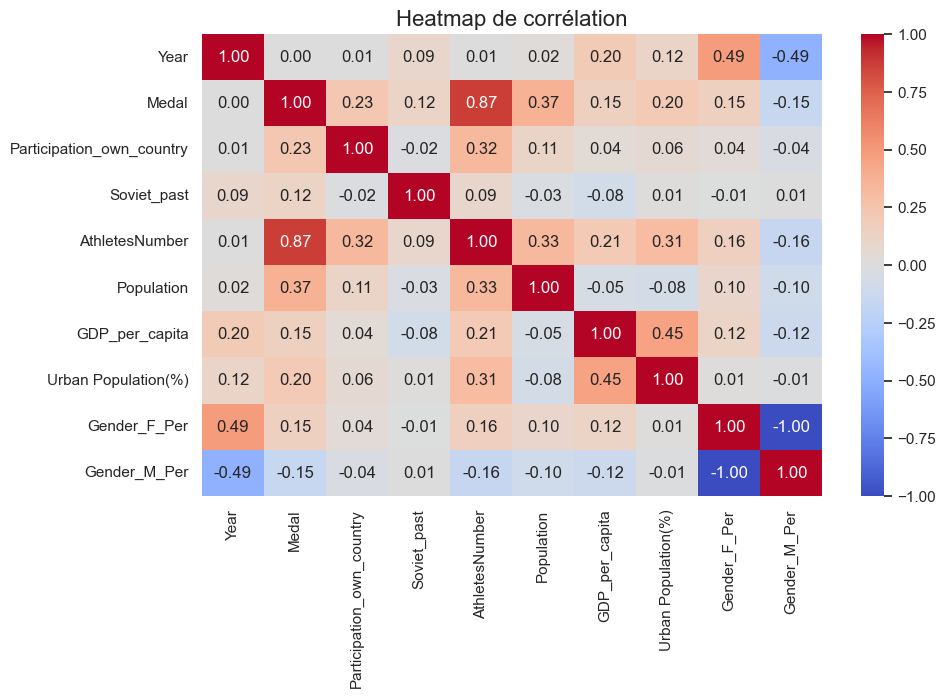

In [560] used 26.1 MiB RAM in 0.52s (system mean cpu 61%, single max cpu 91%), peaked 0.0 MiB above final usage, current RAM usage now 74.2 MiB


In [560]:
# Copier le DataFrame df_gdp_soviet_athlete_sex
df_correl = df_gdp_soviet_athlete_sex.copy()

# Supprimer la colonne 'Pays'
df_correl.drop(columns=['Country'], inplace=True)

correlation_matrix = df_correl.corr()

# Création de la heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_correl.corr(), annot=True, cmap='coolwarm', fmt=".2f")

heatmap.set_title('Heatmap de corrélation', fontsize=16)

#affichage 
plt.show()

In [561]:
#on filtre les variables avec une correlation (negative/positive) forte 
high_correlation = correlation_matrix[(correlation_matrix > 0.8) | (correlation_matrix < -0.8)]
high_correlation = high_correlation.dropna(axis=1, how='all').dropna(axis=0, how='all')

print("Variables avec une corrélation supérieure à 0,80 ou inférieure à -0,80 :")
high_correlation

#on ne remarque pas de variables avec de forte corrélation (>0,80), on ne supprime pas de données

Variables avec une corrélation supérieure à 0,80 ou inférieure à -0,80 :


,Year,Medal,Participation_own_country,Soviet_past,AthletesNumber,Population,GDP_per_capita,Urban Population(%),Gender_F_Per,Gender_M_Per
Year,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medal,NaN,1.000000,NaN,NaN,0.871959,NaN,NaN,NaN,NaN,NaN
Participation_own_country,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Soviet_past,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
AthletesNumber,NaN,0.871959,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
Population,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
GDP_per_capita,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Urban Population(%),NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Gender_F_Per,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1.0
Gender_M_Per,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,1.0


In [561] used 3.1 MiB RAM in 0.12s (system mean cpu 50%, single max cpu 66%), peaked 0.0 MiB above final usage, current RAM usage now 77.3 MiB


## Test des modèles
Ici, nous allons essayer plusieurs modèles de régression et nous allons comparer leur performance (sur la valeur Mean Square Error). Pour les tests, nous allons nous appuyer sur un échantillon de l'ensemble du dataframe, soit des années 1988 à 2020 ; et nous allons aussi essayer de prédire les valeurs de Tokyo dans un second temps en les excluant du jeu d'entraînement. 

### Séparation du train et du test

In [ ]:
# On fait un train/test plus classique, avec toutes les données
X_train, X_test, y_train, y_test = train_test_split(df_gdp_soviet_athlete_sex[['Participation_own_country', 'Soviet_past', 'AthletesNumber', 'GDP_per_capita', 'Population', 'Urban Population(%)', 'Gender_F_Per', 'Gender_M_Per']], df_gdp_soviet_athlete_sex['Medal'], test_size=0.33, random_state=42)

In [ ]:
# On garde un dataset de Tokyo pour tester à part
df_train = df_gdp_soviet_athlete_sex[df_gdp_soviet_athlete_sex['Year'] != 2020]
X_df_train = df_train[['Participation_own_country', 'Soviet_past', 'AthletesNumber',
       'Population', 'GDP_per_capita', 'Urban Population(%)', 'Gender_F_Per',
       'Gender_M_Per']]
y_df_train = df_train['Medal']


df_test = df_gdp_soviet_athlete_sex[df_gdp_soviet_athlete_sex['Year'] == 2020]
X_df_test = df_test[['Participation_own_country', 'Soviet_past', 'AthletesNumber',
       'Population', 'GDP_per_capita', 'Urban Population(%)', 'Gender_F_Per',
       'Gender_M_Per']]
y_df_test = df_test['Medal']

### Recherche des meilleurs paramètres des modèles
Nous allons ici essayer plusieurs modèles, certains trouvés en cours et d'autres sur le web
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor
- XGBoost

Nous allons essayer dans un premier temps de trouver, pour chacun, les meilleurs hyperparamètres possibles, puis nous effectuerons notre choix sur la base de la MSE (Mean Square Error)

Essai de LinearRegression

In [ ]:
# Define the hyperparameters to search over
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1, 1, 2, 4],  # Adjust values as needed
    # Add any other hyperparameters you want to tune
}

# Create a linear regression model
model = LinearRegression()

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Fit the model with the best parameters
best_model = LinearRegression(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Essai du RandomForestRegressor

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_regressor = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_regressor.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Essai du GradientBoostingRegressor

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.05],
    'max_depth': [3]
}

# Create a Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_gb_regressor = grid_search.best_estimator_

# Make predictions on the test data using th    e best model
y_pred = best_gb_regressor.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Test du XGBoost

In [ ]:
# Create the XGBRegressor model
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror')

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (Negative Mean Squared Error):", best_score)


En sachant que plus la Mean Square Error tend vers 0, meilleur le modèle est. 
Voici les résultats des modèles : 
- LinearRegression : MSE=28
- RandomForestRegressor : MSE=10
- GradientBoostingRegressor : MSE=11
- XGBoost : MSE=-28

Deux modèles sortent du lot : RandomForestRegressor et GradientBoostingRegressor. Nous allons ici utiliser le RandomForestRegressor avec les meilleurs paramètres trouvés par GridSearch, à savoir : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Il serait intéressant de connaitre l'importance des features liés à ce modèle.


In [ ]:
feature_importances = best_rf_regressor.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

On observe ici que la feature ayant le plus d'importance est celle reprenant le nombre d'athlètes, et de loin. Cela remet en perspective l'effort de récupération des autres données ...

## Récupération des données de 2024

In [500]:
tables = pd.read_html('https://en.wikipedia.org/wiki/2024_Summer_Olympics')
athlete_per_country = tables[11]

athlete_per_country.drop(columns=['Ranking'], inplace=True)
athlete_per_country.rename({'NOC': 'Country', 'Athletes': 'AthletesNumber'}, axis=1, inplace=True)

athlete_per_country['Year'] = 2024

In [500] used 6.6 MiB RAM in 0.61s (system mean cpu 39%, single max cpu 80%), peaked 0.0 MiB above final usage, current RAM usage now 70.2 MiB


In [501]:
test_merge_2024 = countries_complete.merge(athlete_per_country, left_on=['Country_df_dict'], right_on=['Country'], how='right')
test_merge_2024.drop(columns=['Country_df_iban'], inplace=True)
athlete_per_country

,Country,AthletesNumber,Year
0,United States,501,2024
1,France,485,2024
2,Australia,377,2024
3,Germany,309,2024
4,China,293,2024
...,...,...,...
153,Monaco,1,2024
154,Saint Vincent and the Grenadines,1,2024
155,San Marino,1,2024
156,Togo,1,2024


In [501] used 0.9 MiB RAM in 0.11s (system mean cpu 42%, single max cpu 88%), peaked 0.0 MiB above final usage, current RAM usage now 71.2 MiB


In [502]:
# On a quelques problèmes pour la correspondance, on créée une table de correspondance
print(test_merge_2024[test_merge_2024['Country_df_dict'].isna()])

# On supprime les données sur Individual Neutral Athletes, Chinese Taipei, Refugee Olympic Team, Kosovo, comme ils ne sont plus dans le dataframe d'origine suite à un nettoyage

correspondance_2024 = {
    'Great Britain': 'United Kingdom', 
    'South Korea': 'Korea, South',  
    'Angola[A]' : 'Angola', 
    'Ivory Coast': "Cote d'Ivoire",
    'North Korea': 'Korea, North', 
    'The Gambia': 'Gambia',
    'Palestine': 'Palestine, Occupied Territories',
    'Democratic Republic of the Congo': 'Congo, Dem Rep'
}

test_merge_2024['Country'] = test_merge_2024['Country'].replace(correspondance_2024)

to_delete_2O24 = ['Individual Neutral Athletes', 'Chinese Taipei', 'Refugee Olympic Team', 'Kosovo']

# Convert the list to a DataFrame
to_delete_df = pd.DataFrame(to_delete_2O24, columns=['Country'])

test_merge_2024.drop(columns=['Country_df_dict'], inplace=True)
test_merge_2024 = test_merge_2024[~test_merge_2024['Country'].isin(to_delete_df['Country'])]


    Country_df_dict                           Country  AthletesNumber  Year
7               NaN                     Great Britain             267  2024
18              NaN                       South Korea              97  2024
44              NaN       Individual Neutral Athletes              37  2024
48              NaN                    Chinese Taipei              30  2024
61              NaN                         Angola[A]              20  2024
86              NaN                       Ivory Coast               7  2024
87              NaN                       North Korea               7  2024
110             NaN              Refugee Olympic Team               3  2024
116             NaN                        The Gambia               2  2024
125             NaN                         Palestine               2  2024
140             NaN  Democratic Republic of the Congo               1  2024
147             NaN                            Kosovo               1  2024
In [502] use

In [503]:
#Participation_own_country
test_merge_2024['Participation_own_country'] = np.where(test_merge_2024['Country'] == 'France', 1, 0)

In [503] used 0.1 MiB RAM in 0.10s (system mean cpu 45%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 71.9 MiB


In [504]:
#Soviet_past = on reprend les mêmes valeurs que dans le dataframe de train
soviet_past = df_gdp_soviet_athlete_sex.drop_duplicates(subset=['Country'])
soviet_past.drop(columns=['AthletesNumber', 'Population', 'GDP_per_capita', 'Urban Population(%)',
       'Gender_F_Per', 'Gender_M_Per', 'Medal', 'Participation_own_country', 'Year'], inplace=True)

In [504] used 0.5 MiB RAM in 0.11s (system mean cpu 40%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 72.4 MiB


/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_20885/287008703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soviet_past.drop(columns=['AthletesNumber', 'Population', 'GDP_per_capita', 'Urban Population(%)',


In [505]:
test_merge_2024 = test_merge_2024.merge(soviet_past, on='Country', how='left')

In [505] used 0.1 MiB RAM in 0.11s (system mean cpu 28%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 72.5 MiB


In [506]:
# Les Jeux Olympiques de Paris 2024 étant déclarés comme étant les premiers jeux paritaire de l'histoire, nous partons du postulat que chaque pays envoie autant d'hommes que de femmes, ce qui résulte en une répartition parfaite de 50%/50%
test_merge_2024['Gender_F_Per'] = test_merge_2024['Gender_M_Per'] = 0.5

In [506] used 0.0 MiB RAM in 0.11s (system mean cpu 26%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 72.6 MiB


In [507]:
test_merge_2024

,Country,AthletesNumber,Year,Participation_own_country,Soviet_past,Gender_F_Per,Gender_M_Per
0,United States,501,2024,0,0,0.5,0.5
1,France,485,2024,1,0,0.5,0.5
2,Australia,377,2024,0,0,0.5,0.5
3,Germany,309,2024,0,0,0.5,0.5
4,China,293,2024,0,0,0.5,0.5
...,...,...,...,...,...,...,...
149,Monaco,1,2024,0,0,0.5,0.5
150,Saint Vincent and the Grenadines,1,2024,0,0,0.5,0.5
151,San Marino,1,2024,0,0,0.5,0.5
152,Togo,1,2024,0,0,0.5,0.5


In [507] used 0.1 MiB RAM in 0.11s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 72.6 MiB


N'ayant pas les données de la Banque Mondiale (même source que les données démographiques récupérées précédemment) sur les années 2023 et 2024, nous avons fait le choix de reprendre les données de 2022, afin de faciliter le traitement de ces dernières. 

In [519]:
# On fait un KNN des valeurs démographiques manquantes comprises entre 2015 et 2023 pour avoir plus d'éléments, puis on filtre seulement les données de 2022
pop_gdp_df_to_impute = pop_gdp_df[(pop_gdp_df['Year'] < 2023) & (pop_gdp_df['Year'] > 2015) ]
pop_gdp_df_to_impute = impute_missing_values(pop_gdp_df_to_impute)
pop_gdp_df_to_impute = pop_gdp_df_to_impute[pop_gdp_df_to_impute['Year'] == 2022]

# Final training dataset
final_df_test_2024 = test_merge_2024.merge(pop_gdp_df_to_impute, on='Country', how='inner')

In [519] used 4.6 MiB RAM in 0.12s (system mean cpu 47%, single max cpu 63%), peaked 0.0 MiB above final usage, current RAM usage now 82.9 MiB


/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_20885/909510630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = imputer.fit_transform(df[numerical_columns])


In [523]:
final_df_test_2024.drop(columns=['Year_x'], inplace=True)
final_df_test_2024.rename({'Year_y': 'Year'}, axis=1, inplace=True)


In [523] used -8.8 MiB RAM in 0.11s (system mean cpu 41%, single max cpu 65%), peaked 0.0 MiB above final usage, current RAM usage now 61.9 MiB


In [531]:
df_gdp_soviet_athlete_sex.Year.min()

1984

In [531] used -4.6 MiB RAM in 0.11s (system mean cpu 54%, single max cpu 75%), peaked 0.0 MiB above final usage, current RAM usage now 43.6 MiB


## Application du modèle
Nous avons donc choisi d'utiliser le modèle RandomForestRegressor avec les paramètres suivants : 
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

In [532]:
df_gdp_soviet_athlete_sex.columns

Index(['Country', 'Year', 'Medal', 'Participation_own_country', 'Soviet_past',
       'AthletesNumber', 'Population', 'GDP_per_capita', 'Urban Population(%)',
       'Gender_F_Per', 'Gender_M_Per'],
      dtype='object')

In [532] used 0.9 MiB RAM in 0.10s (system mean cpu 46%, single max cpu 63%), peaked 0.0 MiB above final usage, current RAM usage now 44.5 MiB


In [542]:
# Train 
# df_gdp_soviet_athlete_sex
X_train = df_gdp_soviet_athlete_sex[['Participation_own_country', 'Soviet_past',
       'AthletesNumber', 'Population', 'GDP_per_capita', 'Urban Population(%)',
       'Gender_F_Per', 'Gender_M_Per']]
y_train = df_gdp_soviet_athlete_sex['Medal']


# Test
# final_df_test_2024
X_test = final_df_test_2024

hyperparameters = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(**hyperparameters, random_state=42)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test[['Participation_own_country', 'Soviet_past',
       'AthletesNumber', 'Population', 'GDP_per_capita', 'Urban Population(%)',
       'Gender_F_Per', 'Gender_M_Per']])


In [542] used -24.5 MiB RAM in 0.36s (system mean cpu 39%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 50.7 MiB


In [554]:
# Extract country information from final_df_test_2024
countries = final_df_test_2024['Country']

# Create the olympic_2024_pred DataFrame with country and predictions
olympic_2024_pred = pd.DataFrame({'Country': countries, 'Predictions': y_pred})

# Display the olympic_2024_pred DataFrame
print(olympic_2024_pred.sort_values(by='Predictions', ascending=False))

                              Country  Predictions
0                       United States    99.000000
1                              France    72.960000
4                               China    53.747333
3                             Germany    41.728000
7                      United Kingdom    36.423333
..                                ...          ...
149  Saint Vincent and the Grenadines     0.007275
124                          Suriname     0.007192
104                           Bahamas     0.006972
123                       Saint Lucia     0.005533
103                             Aruba     0.005053

[153 rows x 2 columns]
In [554] used 1.2 MiB RAM in 0.11s (system mean cpu 32%, single max cpu 61%), peaked 0.0 MiB above final usage, current RAM usage now 47.4 MiB


In [555]:
sum_predicted_2024 = olympic_2024_pred['Predictions'].sum()
expected_medals_2024 = 987

evol_percentage =  expected_medals_2024 / sum_predicted_2024

In [555] used 0.1 MiB RAM in 0.11s (system mean cpu 60%, single max cpu 91%), peaked 0.0 MiB above final usage, current RAM usage now 47.5 MiB


In [558]:
# Ajustement en fonction du % d'évolution
olympic_2024_pred['Predictions'] = round(olympic_2024_pred['Predictions']* evol_percentage)
olympic_2024_pred['Predictions'] = olympic_2024_pred['Predictions'].astype('int')

In [558] used 0.0 MiB RAM in 0.11s (system mean cpu 43%, single max cpu 63%), peaked 0.0 MiB above final usage, current RAM usage now 47.6 MiB


In [559]:
olympic_2024_pred

,Country,Predictions
0,United States,206
1,France,151
2,Australia,71
3,Germany,87
4,China,111
...,...,...
148,Monaco,0
149,Saint Vincent and the Grenadines,0
150,San Marino,3
151,Togo,0


In [559] used 0.4 MiB RAM in 0.11s (system mean cpu 45%, single max cpu 66%), peaked 0.0 MiB above final usage, current RAM usage now 48.1 MiB


Nous avons prédit les médailles de 2024. Au total, lors de l'exécution de l'algorithme, nous avons conclu à un total de médailles distribué de 685. Or, dans la mesure où il y a 329 évènements prévus lors de Paris 2024, cela correspond à 987 médailles au total. 
Nous allons donc extrapoler le nombre de médailles en fonction, en effectuant une règle de 3. 

Cependant, il est important de noter que nous n'avons pas la totalité des compétiteurs dans cette liste, dans la mesure où nous avons retiré les réfugiés et les compétiteurs individuels (pour lesquels nous ne pouvons pas trouver de données) ; ainsi que quelques pays dont les données démographiques ne figuraient pas dans les données de la Banque Mondiale. 

Il semble aussi bon de rappeler que les données démographiques utilisées ici datent de 2022, alors qu'il aura fallu, dans l'idéal, les données de 2023, que nous n'avons malheureusement pas à notre disposition. 